In [7]:
# RAFT Optical Flow Motion Detection
# (Without Monodepth2 dependency)

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Video: 756 frames, 30.00 FPS, 848x464


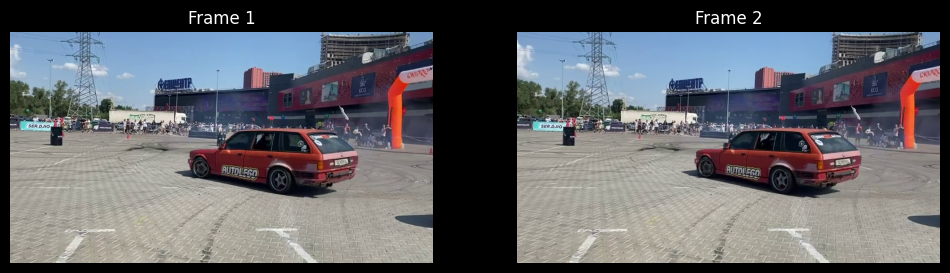

In [8]:
# Video setup
video_path = Path("data/videos/test_video_3.mp4")
cap = cv2.VideoCapture(str(video_path))

n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video: {n_frames} frames, {fps:.2f} FPS, {width}x{height}")

# Read two sample frames for testing
cap.set(cv2.CAP_PROP_POS_FRAMES, n_frames // 2)
ret, frame1 = cap.read()
ret, frame2 = cap.read()
cap.release()

frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(frame1_rgb)
axes[0].set_title("Frame 1")
axes[0].axis('off')
axes[1].imshow(frame2_rgb)
axes[1].set_title("Frame 2")
axes[1].axis('off')
plt.show()

In [9]:
# Load RAFT model from torchvision
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

raft_weights = Raft_Large_Weights.DEFAULT
raft_model = raft_large(weights=raft_weights, progress=True).to(device)
raft_model.eval()

raft_transforms = raft_weights.transforms()

print("RAFT model loaded successfully!")

RAFT model loaded successfully!


In [10]:
def compute_raft_flow(model, transforms, img1, img2, device):
    """Compute optical flow using RAFT."""
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    img1_tensor = torch.from_numpy(img1_rgb).permute(2, 0, 1).float().unsqueeze(0)
    img2_tensor = torch.from_numpy(img2_rgb).permute(2, 0, 1).float().unsqueeze(0)
    
    img1_batch, img2_batch = transforms(img1_tensor, img2_tensor)
    img1_batch = img1_batch.to(device)
    img2_batch = img2_batch.to(device)
    
    with torch.no_grad():
        flow = model(img1_batch, img2_batch)[-1]
    
    flow_np = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow_np

def flow_to_color(flow):
    """Convert optical flow to color visualization."""
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    
    mag, ang = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
    hsv[:, :, 0] = ang * 180 / np.pi / 2
    hsv[:, :, 1] = 255
    hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def detect_moving_objects_flow(flow, threshold_std=2.0):
    """Detect moving objects by finding flow outliers."""
    median_dx = np.median(flow[:, :, 0])
    median_dy = np.median(flow[:, :, 1])
    
    residual_x = flow[:, :, 0] - median_dx
    residual_y = flow[:, :, 1] - median_dy
    residual_mag = np.sqrt(residual_x**2 + residual_y**2)
    
    mean_residual = np.mean(residual_mag)
    std_residual = np.std(residual_mag)
    threshold = mean_residual + threshold_std * std_residual
    
    moving_mask = residual_mag > threshold
    return moving_mask, residual_mag

# Compute flow between sample frames
print("Computing RAFT optical flow...")
raft_flow = compute_raft_flow(raft_model, raft_transforms, frame1, frame2, device)
print(f"Flow shape: {raft_flow.shape}")

Computing RAFT optical flow...
Flow shape: (464, 848, 2)


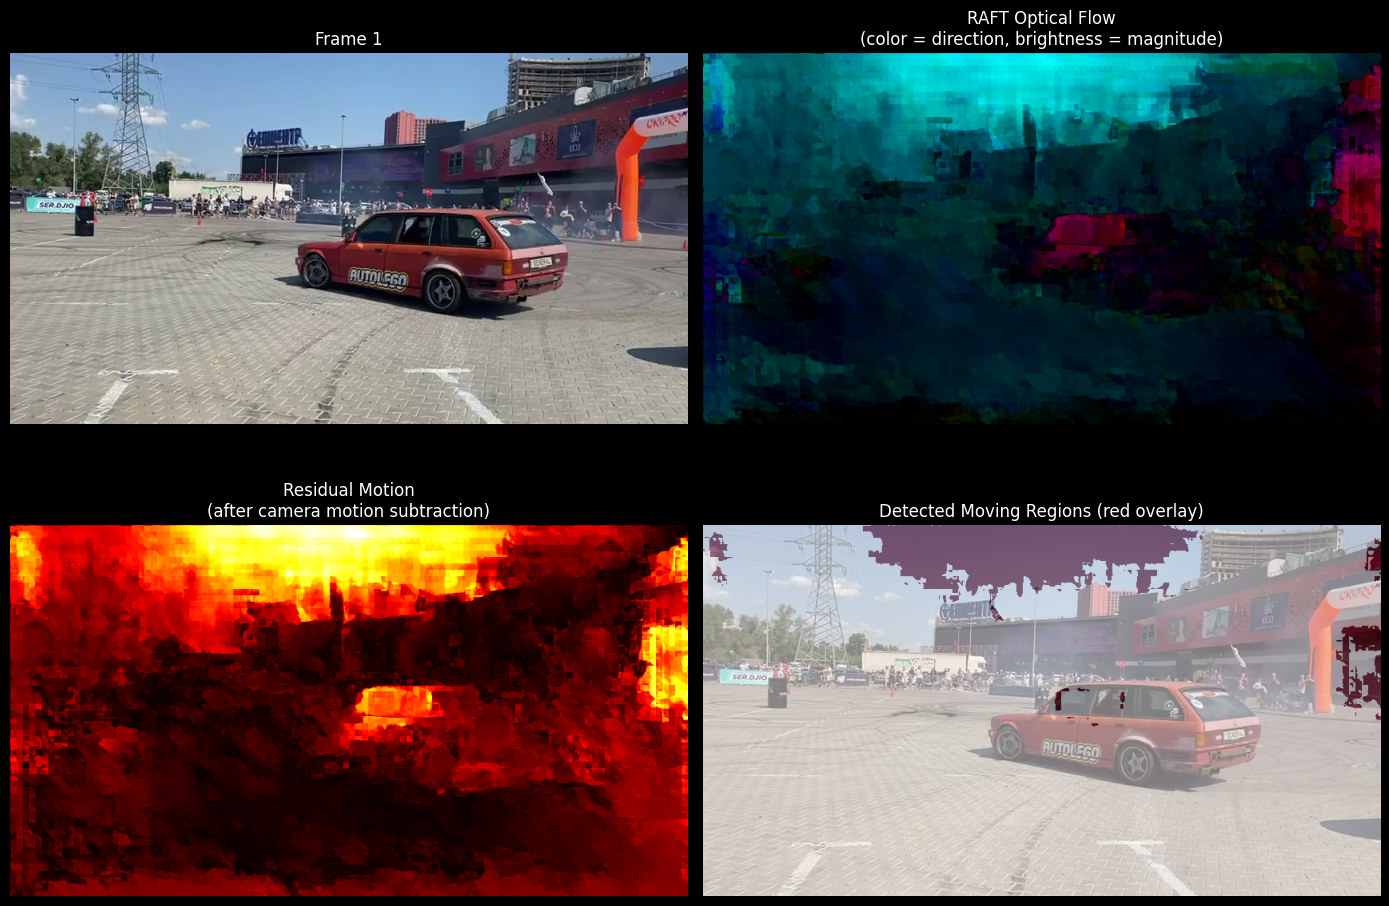

Camera motion estimate: dx=-76.32, dy=-21.76
Moving pixels: 30656 (7.8% of frame)


In [11]:
# Visualize RAFT results
flow_color = flow_to_color(raft_flow)
moving_mask, residual = detect_moving_objects_flow(raft_flow)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(frame1_rgb)
axes[0, 0].set_title("Frame 1")
axes[0, 0].axis('off')

axes[0, 1].imshow(flow_color)
axes[0, 1].set_title("RAFT Optical Flow\n(color = direction, brightness = magnitude)")
axes[0, 1].axis('off')

axes[1, 0].imshow(residual, cmap='hot')
axes[1, 0].set_title("Residual Motion\n(after camera motion subtraction)")
axes[1, 0].axis('off')

axes[1, 1].imshow(frame1_rgb)
axes[1, 1].imshow(moving_mask, alpha=0.5, cmap='Reds')
axes[1, 1].set_title("Detected Moving Regions (red overlay)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Camera motion estimate: dx={np.median(raft_flow[:,:,0]):.2f}, dy={np.median(raft_flow[:,:,1]):.2f}")
print(f"Moving pixels: {moving_mask.sum()} ({100*moving_mask.mean():.1f}% of frame)")

In [ ]:
# ===========================================
# PROCESS FULL VIDEO
# ===========================================

output_dir = Path("data")
motion_dir = output_dir / "raft_motion_frames"
flow_dir = output_dir / "raft_flow_frames"

motion_dir.mkdir(parents=True, exist_ok=True)
flow_dir.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(str(video_path))
ret, prev_frame = cap.read()

frame_idx = 0
max_frames = n_frames  # Limit for testing (set to n_frames for full video)

print(f"Processing {max_frames} frames...")

while frame_idx < max_frames:
    ret, curr_frame = cap.read()
    if not ret:
        break
    
    # Compute RAFT flow
    flow = compute_raft_flow(raft_model, raft_transforms, prev_frame, curr_frame, device)
    
    # Convert flow to color visualization
    flow_color = flow_to_color(flow)
    flow_color_bgr = cv2.cvtColor(flow_color, cv2.COLOR_RGB2BGR)
    
    # Detect moving objects
    moving_mask, _ = detect_moving_objects_flow(flow)
    
    # Draw motion detection result
    frame_motion = curr_frame.copy()
    
    # Resize mask to frame size if needed
    if moving_mask.shape != curr_frame.shape[:2]:
        moving_mask = cv2.resize(moving_mask.astype(np.uint8), 
                                  (curr_frame.shape[1], curr_frame.shape[0])).astype(bool)
    
    # Resize flow visualization to frame size
    flow_color_resized = cv2.resize(flow_color_bgr, (curr_frame.shape[1], curr_frame.shape[0]))
    
    # Overlay moving regions (red)
    frame_motion[moving_mask] = [0, 0, 255]
    
    # Save outputs
    cv2.imwrite(str(motion_dir / f"frame_{frame_idx:04d}.png"), frame_motion)
    cv2.imwrite(str(flow_dir / f"frame_{frame_idx:04d}.png"), flow_color_resized)
    
    prev_frame = curr_frame
    frame_idx += 1
    
    if frame_idx % 10 == 0:
        print(f"  Processed {frame_idx}/{max_frames} frames")

cap.release()
print(f"\nDone! Saved to:")
print(f"  {motion_dir} - Motion detection (red overlay)")
print(f"  {flow_dir} - Optical flow visualization")